In [ ]:
# mount drive and change directory to project folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/520 Final Project"

/content/drive/.shortcut-targets-by-id/1KHBlsdIi36o_ikonJZ-usBVzGPrZlH0V/520 Final Project


#loading data

In [ ]:
import numpy as np
with open("X_train_RNN.npy", 'rb') as f:
  X_train_RNN = np.load(f)
with open("X_test_RNN.npy", 'rb') as f:
  X_test_RNN = np.load(f)
with open("y_train_RNN.npy", 'rb') as f:
  y_train_RNN = np.load(f)[:,:,40:85]
with open("y_test_RNN.npy", 'rb') as f:
  y_test_RNN = np.load(f)[:,:,40:85]

In [ ]:
X_train_RNN = X_train_RNN.reshape((X_train_RNN.shape[0], X_train_RNN.shape[1], -1))
X_test_RNN = X_test_RNN.reshape((X_test_RNN.shape[0], X_test_RNN.shape[1], -1))

In [ ]:
# only consider the final value of our RNN
y_train_RNN = y_train_RNN[:,-1,:]
y_test_RNN = y_test_RNN[:,-1,:]

In [ ]:
X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape

((16170, 20, 2688), (16170, 45), (193, 20, 2688), (193, 45))

#messing around with data

In [ ]:
print(y_train_RNN[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(X_train_RNN[0, 1, :])

[-57.979733 -58.536106 -59.15738  ... -75.563156 -78.80462  -80.      ]


# Define LSTM model

In [ ]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.autograd import Variable 

In [ ]:
# modified from https://cnvrg.io/pytorch-lstm/
class LSTM1(nn.Module):
    def __init__(self):
        super(LSTM1, self).__init__()
        self.num_classes = 45 #number of classes
        self.num_layers = 1 #number of layers
        self.input_size = 84*32 #input size
        self.hidden_size = 100 #hidden state
        self.seq_length = 20 #sequence length

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(self.hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, self.num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
#just curious how CNN works on RNN data
class CNN1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=1)
    self.batch_1 = nn.BatchNorm2d(4)
    self.conv_2 = torch.nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 5, stride = 1, padding = 1)
    self.batch_2 = nn.BatchNorm2d(8)
    self.linear_1 = torch.nn.Linear(16080, 128)
    self.linear_2 = torch.nn.Linear(128, 45)
    self.relu = torch.nn.ReLU()
    self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.dropout = nn.Dropout(p = 0.8)
  def forward(self, x):
      x = x.reshape((x.size(0), 1, x.size(1), x.size(2))) #as CNN expects [B, Cin, H, W] as output, converts from [B, H, W] --> [B, Cin, H, W]
      x = self.relu(self.conv_1(x))
      x = self.batch_1(x)
      x = self.max_pool2d(x)
      x = self.relu(self.conv_2(x))
      x = self.batch_2(x)
      x = self.max_pool2d(x)
      x = self.dropout(x)

      x = x.reshape((x.size(0), -1))
      x = self.relu(self.linear_1(x))
      x = self.linear_2(x)
      return x

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self):
    super(VanillaRNN, self).__init__()
    self.input_size = 84 * 32
    self.hidden_size = 100
    self.num_layers = 4
    self.num_classes = 45
    self.seq_length = 20
    self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first = True)
    self.fc = nn.Linear(self.hidden_size * self.seq_length, self.num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out 

#training the model (don't run again)



In [ ]:
#put data into trainloader
trainset = []
for i in range(len(X_train_RNN)):
  trainset.append([X_train_RNN[i], y_train_RNN[i]])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [ ]:
from torch.nn.modules.loss import BCEWithLogitsLoss
epochs = 2
model = LSTM1()
criterion = BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6) 
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        #print("image: " + str(image.shape))
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        #print("label: " + str(label.shape))
        #print("y_predicted: " + str(y_predicted.shape))
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    with torch.no_grad():
      totalPos = 0
      for i in range(45):
        totalPos += np.count_nonzero(y_predicted.numpy()[:, i] > 0)
      print("num of positive: " + str(totalPos))
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

num of positive: 75
epoch: 1, loss: 681.9117
num of positive: 49
epoch: 2, loss: 654.0702


In [ ]:
torch.save(model.state_dict(), 'RNNafterQTransform7.pt')

#loading and testing the model

In [ ]:
model2 = LSTM1()
model2.load_state_dict(torch.load('RNNafterQTransform2.pt'))
model2.eval()

LSTM1(
  (lstm): LSTM(2688, 100, batch_first=True)
  (fc_1): Linear(in_features=100, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=45, bias=True)
  (relu): ReLU()
)

In [ ]:
with torch.no_grad():
  X = torch.tensor(X_train_RNN).float()
  trainPreds = model2(X)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracies = []
recalls = []
precisions = []
for i in range(45):
  accuracies += [accuracy_score((trainPreds.numpy()[:,i] > 0), y_train_RNN[:,i])]
  recalls += [recall_score((trainPreds.numpy()[:,i] > 0), y_train_RNN[:,i], zero_division=0)]
  precisions += [precision_score((trainPreds.numpy()[:,i] > 0), y_train_RNN[:,i], zero_division=0)]

In [ ]:
print(accuracies)
print(recalls)
print(precisions)

In [ ]:
with torch.no_grad():
  X = torch.tensor(X_test_RNN).float()
  testPreds = model2(X)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
accuracies = []
recalls = []
precisions = []
for i in range(45):
  accuracies += [accuracy_score((testPreds.numpy()[:,i] > 0), y_test_RNN[:,i])]
  recalls += [recall_score((testPreds.numpy()[:,i] > 0), y_test_RNN[:,i], zero_division=0)]
  precisions += [precision_score((testPreds.numpy()[:,i] > 0), y_test_RNN[:,i], zero_division=0)]

In [ ]:
print(accuracies) 
print(recalls)
print(precisions)

[0.9844559585492227, 0.9740932642487047, 0.9792746113989638, 0.9844559585492227, 0.9533678756476683, 0.9689119170984456, 0.9637305699481865, 0.9637305699481865, 0.9378238341968912, 0.9844559585492227, 0.9222797927461139, 0.9378238341968912, 0.9740932642487047, 0.9585492227979274, 0.9689119170984456, 0.8860103626943006, 0.9378238341968912, 0.9689119170984456, 0.9326424870466321, 0.9689119170984456, 0.8860103626943006, 0.9637305699481865, 0.9222797927461139, 0.9015544041450777, 0.9378238341968912, 0.9119170984455959, 0.927461139896373, 0.9119170984455959, 0.9222797927461139, 0.9378238341968912, 0.9533678756476683, 0.9378238341968912, 0.9326424870466321, 0.927461139896373, 0.9326424870466321, 0.927461139896373, 0.9740932642487047, 0.9740932642487047, 0.9481865284974094, 0.9533678756476683, 0.9481865284974094, 0.9740932642487047, 0.9844559585492227, 0.9896373056994818, 0.9792746113989638]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
#mean recalls
print(np.mean(accuracies))
print(recalls[20])
print(precisions[20])

0.9491076568796777
0.0
0.0


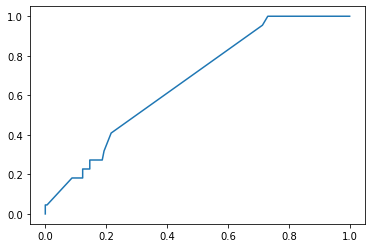

In [ ]:
# ROC curve for middle C: MIDI 60, so index 20
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_RNN[:,20], testPreds[:,20])
plt.plot(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.6677299308878257


In [ ]:
# get the average AUC over all the notes
aucs = []
for i in range(45):
  fpr, tpr, _ = roc_curve(y_test_RNN[:,i], testPreds[:,i])
  aucs += [auc(fpr,tpr)]
print(np.mean(aucs))

0.5115049273957488


In [ ]:
import pickle
with open('rnn_fpr.npy', 'wb') as f:
  np.save(f, fpr, allow_pickle=True)
with open('rnn_tpr.npy', 'wb') as f:
  np.save(f, tpr, allow_pickle=True)

#some weird things

In [ ]:
print(np.count_nonzero(testPreds.numpy()[:, 0] > 0))

0


In [ ]:
print(np.count_nonzero(y_train_RNN[:, 0] > 0))

399


In [ ]:
print(testPreds.numpy()[:, 44])

[-3.2578683 -3.1696558 -3.1968868 -3.1986892 -3.1993644 -3.2317178
 -3.1949139 -3.1786819 -3.1851861 -3.2303634 -3.2346544 -3.2308452
 -3.246705  -3.1968894 -3.1994174 -3.199385  -3.2457583 -3.1991835
 -3.245648  -3.1994174 -3.2345314 -3.19739   -3.123517  -3.1994164
 -3.2051604 -3.2610917 -3.2519531 -3.2607074 -3.2609758 -3.2463322
 -3.2494218 -3.230083  -3.2549524 -3.2602496 -3.2587416 -3.234071
 -3.2423074 -3.2581758 -3.2368982 -3.2464871 -3.2072446 -3.2403152
 -3.2606673 -3.2341917 -3.2601292 -3.2501202 -3.2351544 -3.2275543
 -3.1935124 -3.2401078 -3.233888  -3.1401129 -3.242065  -3.1888838
 -3.2610226 -3.1416347 -3.1924148 -3.233739  -3.2582355 -3.1390386
 -3.1721425 -3.2590494 -3.0763016 -3.2583401 -3.234321  -3.2610347
 -3.2369554 -3.2606652 -3.2176046 -3.1403434 -3.2577047 -3.254584
 -3.147092  -3.2132747 -3.1454792 -3.2151532 -3.26057   -3.2601871
 -3.1266897 -3.2329516 -3.2151532 -3.2127116 -3.2419999 -3.2151532
 -3.143342  -3.2470171 -3.2314525 -3.2569458 -3.2151527 -3.23521

In [ ]:
print(y_test_RNN[:, 20])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0.]
